# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA    

# Printing options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
%pprint
# Pretty display for notebooks
%matplotlib inline

Pretty printing has been turned OFF


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head(5)


(891221, 85)


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0 -1         2                     1          2.0             
1 -1         1                     2          5.0             
2 -1         3                     2          3.0             
3  2         4                     2          2.0             
4 -1         3                     1          5.0             

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0  3                  4              3                 5                
1  1                  5              2                 5                
2  1                  4              1                 2                
3  4                  2              5                 2                
4  4                  3              4                 1                

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0  5                      3                 4          0             
1  4                      5                 1          1996          
2  3                      5                 1          1979          
3  1                      2                 6          1957          
4  3                      2                 5          1963          

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0  10.0             0                -1           15.0                  
1  10.0             0                 3           21.0                  
2  10.0             1                 3           3.0                   
3  1.0              0                 2           0.0                   
4  5.0              0                 3           32.0                  

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0  4.0                  2.0              2.0              1.0              
1  6.0                  5.0              3.0              2.0              
2  1.0                  1.0              1.0              3.0              
3  0.0                  0.0              0.0              9.0              
4  10.0                 10.0             5.0              3.0              

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0  1.0             0                 0                      5.0              
1  1.0             1                 14                     1.0              
2  2.0             1                 15                     3.0              
3  4.0             1                 8                      2.0              
4  2.0             1                 8                      5.0              

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0  2          6          7          5          1           5            
1  5          4          4          3          1           2            
2  4          1          3          3          4           4            
3  5          1          2          1          4           4            
4  6          4          4          2          7           4            

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0  3          3           4          7           6          6            
1  2          3           6          4           7          4            
2  6          3           4          7           7          7            
3  7          4           3          4           4          5            
4  4          6           2          3           2          2            

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0  5              3           -1           NaN      NaN       -1          
1  7              6            3            1.0      0.0       2          
2  3              3            2            0.0      0.0       1          
3  4              4            1            0.0      0.0       1          
4  4              2            2            0.0      0.0       2          

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [4]:
azdias.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000  891221.000000         891221.000000  886367.000000   
mean  -0.358435       2.777398              1.522098       3.632838        
std    1.198724       1.068775              0.499512       1.595021        
min   -1.000000       1.000000              1.000000       1.000000        
25%   -1.000000       2.000000              1.000000       2.000000        
50%   -1.000000       3.000000              2.000000       4.000000        
75%   -1.000000       4.000000              2.000000       5.000000        
max    3.000000       9.000000              2.000000       6.000000        

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count  891221.000000      891221.000000  891221.000000     891221.000000    
mean   3.074528           2.821039       3.401106          3.033328         
std    1.321055           1.464749       1.322134          1.529603         
min    1.000000           1.000000       1.000000          1.000000         
25%    2.000000           1.000000       3.000000          2.000000         
50%    3.000000           3.000000       3.000000          3.000000         
75%    4.000000           4.000000       5.000000          5.000000         
max    5.000000           5.000000       5.000000          5.000000         

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      FINANZTYP    GEBURTSJAHR  \
count  891221.000000          891221.000000     891221.000000  891221.000000   
mean   2.874167               3.075121          3.790586       1101.178533     
std    1.486731               1.353248          1.987876       976.583551      
min    1.000000               1.000000          1.000000       0.000000        
25%    2.000000               2.000000          2.000000       0.000000        
50%    3.000000               3.000000          4.000000       1943.000000     
75%    4.000000               4.000000          6.000000       1970.000000     
max    5.000000               5.000000          6.000000       2017.000000     

       GFK_URLAUBERTYP  GREEN_AVANTGARDE     HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
count  886367.000000    891221.000000     891221.000000  886367.000000         
mean   7.350304         0.196612          1.792102       14.622637             
std    3.525723         0.397437          1.269062       12.616883             
min    1.000000         0.000000         -1.000000       0.000000              
25%    5.000000         0.000000          1.000000       4.000000              
50%    8.000000         0.000000          2.000000       11.000000             
75%    10.000000        0.000000          3.000000       27.000000             
max    12.000000        1.000000          3.000000       40.000000             

       LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
count  886367.000000        886367.000000    886367.000000    886367.000000    
mean   4.453621             3.599574         2.185966         4.791151         
std    3.855639             3.926486         1.756537         3.425305         
min    0.000000             0.000000         0.000000         1.000000         
25%    1.000000             1.000000         1.000000         2.000000         
50%    3.000000             1.000000         1.000000         4.000000         
75%    8.000000             8.000000         4.000000         9.000000         
max    12.000000            11.000000        5.000000         10.000000        

       LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
count  886367.000000   891221.000000     891221.000000           
mean   2.432575        1.026827          8.154346                
std    1.474315        0.586634          4.844532                
min    1.000000        0.000000          0.000000                
25%    1.000000        1.000000          5.000000                
50%    2.000000        1.000000          8.000000                
75%    4

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
feat_info.head(5)

attribute information_level         type missing_or_unknown
0  AGER_TYP              person            categorical  [-1,0]           
1  ALTERSKATEGORIE_GROB  person            ordinal      [-1,0,9]         
2  ANREDE_KZ             person            categorical  [-1,0]           
3  CJT_GESAMTTYP         person            categorical  [0]              
4  FINANZ_MINIMALIST     person            ordinal      [-1]

In [7]:
feat_info.describe()

attribute information_level     type missing_or_unknown
count   85           85                85       85               
unique  85           9                 5        9                
top     GEBURTSJAHR  person            ordinal  [-1]             
freq    1            43                49       26

In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[]').str.split(',')
feat_info.head(5) # Still each value is string


attribute information_level         type missing_or_unknown
0  AGER_TYP              person            categorical  [-1, 0]          
1  ALTERSKATEGORIE_GROB  person            ordinal      [-1, 0, 9]       
2  ANREDE_KZ             person            categorical  [-1, 0]          
3  CJT_GESAMTTYP         person            categorical  [0]              
4  FINANZ_MINIMALIST     person            ordinal      [-1]

In [10]:
start = time.time()
for index in range(feat_info.shape[0]): #feat_info.shape[0]
    #print('Before integer conversion: {}'.format(feat_info.loc[index, 'missing_or_unknown']))
    for item in range(len(feat_info.loc[index, 'missing_or_unknown'])):
        try: 
            feat_info.loc[index, 'missing_or_unknown'][item] = int( feat_info.loc[index, 'missing_or_unknown'][item] )
            #[int(x) for x in feat_info.loc[index, 'missing_or_unknown']]
        #print('After integer conversion: {}'.format(feat_info.loc[index, 'missing_or_unknown']))
        
        except: 
            #print('Error approached cases - index: {}, values: {}'.format(index, feat_info.loc[index, 'missing_or_unknown']))
            continue
#         Error approached cases - index: 12, values: ['']
#         Error approached cases - index: 13, values: ['']
#         Error approached cases - index: 44, values: ['']
#         Error approached cases - index: 45, values: ['']
#         Error approached cases - index: 51, values: ['']
#         Error approached cases - index: 53, values: ['']
#         Error approached cases - index: 57, values: [-1, 'X']
#         Error approached cases - index: 58, values: ['XX']
#         Error approached cases - index: 59, values: [-1, 'XX']
#         Error approached cases - index: 69, values: ['']
#         Error approached cases - index: 71, values: ['']
#         Error approached cases - index: 72, values: ['']
#         Error approached cases - index: 74, values: ['']

    # Replace unknown or missing indicator variables to np.nan
    azdias.loc[:, feat_info.loc[index, 'attribute']].replace(feat_info.loc[index, 'missing_or_unknown'], 
                                                              np.nan, inplace = True)

execution_time = time.time() - start
print("Execution time: {:.4f} seconds".format(execution_time))

    

Execution time: 3.3990 seconds


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing_col = azdias.isnull().sum()
missing_col


AGER_TYP                 685843
ALTERSKATEGORIE_GROB     2881  
ANREDE_KZ                0     
CJT_GESAMTTYP            4854  
FINANZ_MINIMALIST        0     
FINANZ_SPARER            0     
FINANZ_VORSORGER         0     
FINANZ_ANLEGER           0     
FINANZ_UNAUFFAELLIGER    0     
FINANZ_HAUSBAUER         0     
FINANZTYP                0     
GEBURTSJAHR              392318
GFK_URLAUBERTYP          4854  
GREEN_AVANTGARDE         0     
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN      97632 
LP_LEBENSPHASE_GROB      94572 
LP_FAMILIE_FEIN          77792 
LP_FAMILIE_GROB          77792 
LP_STATUS_FEIN           4854  
LP_STATUS_GROB           4854  
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S           4854  
SEMIO_SOZ                0     
SEMIO_FAM                0     
SEMIO_REL                0     
SEMIO_MAT                0     
SEMIO_VERT               0     
SEMIO_LUST               0     
                        ..     
OST_WEST

count    85.000000
mean     11.054139
std      16.449815
min      0.000000 
25%      0.000000 
50%      10.451729
75%      13.073637
max      99.757636
dtype: float64
AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


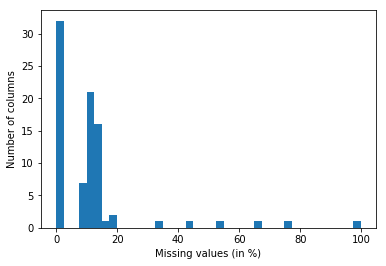

In [12]:
# Investigate patterns in the amount of missing data in each column.
missing_in_percent = missing_col / len(azdias) * 100
print(missing_in_percent.describe())

top_columns = missing_in_percent[missing_in_percent > 20]
print(top_columns)

plt.hist(missing_in_percent, bins = 40)
plt.xlabel('Missing values (in %)')
plt.ylabel('Number of columns')
plt.show()


In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(top_columns.index.tolist(), axis = 1)
azdias.head()


ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0  2.0                   1          2.0            3                   
1  1.0                   2          5.0            1                   
2  3.0                   2          3.0            1                   
3  4.0                   2          2.0            4                   
4  3.0                   1          5.0            4                   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0  4              3                 5               5                       
1  5              2                 5               4                       
2  4              1                 2               3                       
3  2              5                 2               1                       
4  3              4                 1               3                       

   FINANZ_HAUSBAUER  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  \
0  3                 4          10.0             0                NaN           
1  5                 1          10.0             0                 3.0          
2  5                 1          10.0             1                 3.0          
3  2                 6          1.0              0                 2.0          
4  2                 5          5.0              0                 3.0          

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  \
0  15.0                 4.0                  2.0              2.0               
1  21.0                 6.0                  5.0              3.0               
2  3.0                  1.0                  1.0              1.0               
3 NaN                  NaN                  NaN              NaN                
4  32.0                 10.0                 10.0             5.0               

   LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
0  1.0             1.0            NaN               NaN                      
1  2.0             1.0             1.0               14.0                    
2  3.0             2.0             1.0               15.0                    
3  9.0             4.0             1.0               8.0                     
4  3.0             2.0             1.0               8.0                     

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
0  5.0             2          6          7          5          1            
1  1.0             5          4          4          3          1            
2  3.0             4          1          3          3          4            
3  2.0             5          1          2          1          4            
4  5.0             6          4          4          2          7            

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
0  5           3          3           4          7           6           
1  2           2          3           6          4           7           
2  4           6          3           4          7           7           
3  4           7          4           3          4           4           
4  4           4          6           2          3           2           

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  VERS_TYP  \
0  6           5              3           NaN          NaN      NaN         
1  4           7              6            3.0          1.0      2.0        
2  7           3              3            2.0          0.0      1.0        
3  5           4              4            1.0          0.0      1.0        
4  2           4              2            2.0          0.0      2.0        

   ZABEOTYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
0  3        NaN           NaN         2.0                NaN               
1  5         2.0           0.0        6.0                 3.0              
2  5         1.0           0.0        4.0                 3.0    

#### Discussion 1.1.2: Assess Missing Data in Each Column

For most of columns in this dataset, missing values are less than 20% of the entire observation. In average, each column holds around 11% of missing values.

There are total 6 columns, which missing values took more than 20% - AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, and KBA05_BAUMAX, and these columns are removed from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. **Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.**

In order to know what to do with the outlier rows, **we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups**. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Total number of rows with at least one missing value: 268012
Total rows in the dataset: 891221


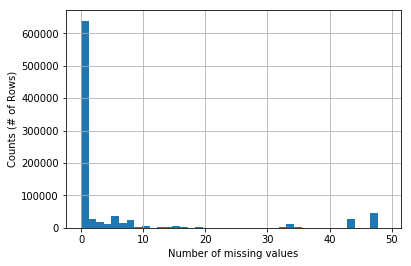

In [14]:
# How much data is missing in each row of the dataset?
missing_rows = azdias.isnull().sum(axis = 1)
print('Total number of rows with at least one missing value: {}'.format(sum(azdias.isnull().any(axis = 1))))
print('Total rows in the dataset: {}'.format(azdias.shape[0]))

plt.hist(missing_rows, bins = 40)
plt.xlabel('Number of missing values')
plt.ylabel('Counts (# of Rows)')
plt.grid(True)
plt.show()


In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Divide into two groups based on the missing value of 10
azdias_low = azdias[missing_rows <= 10].reset_index(drop = True)
print(azdias_low.shape) # head()

azdias_high = azdias[missing_rows > 10].reset_index(drop = True)
print(azdias_high.shape) # head()



(780153, 79)
(111068, 79)


['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER']


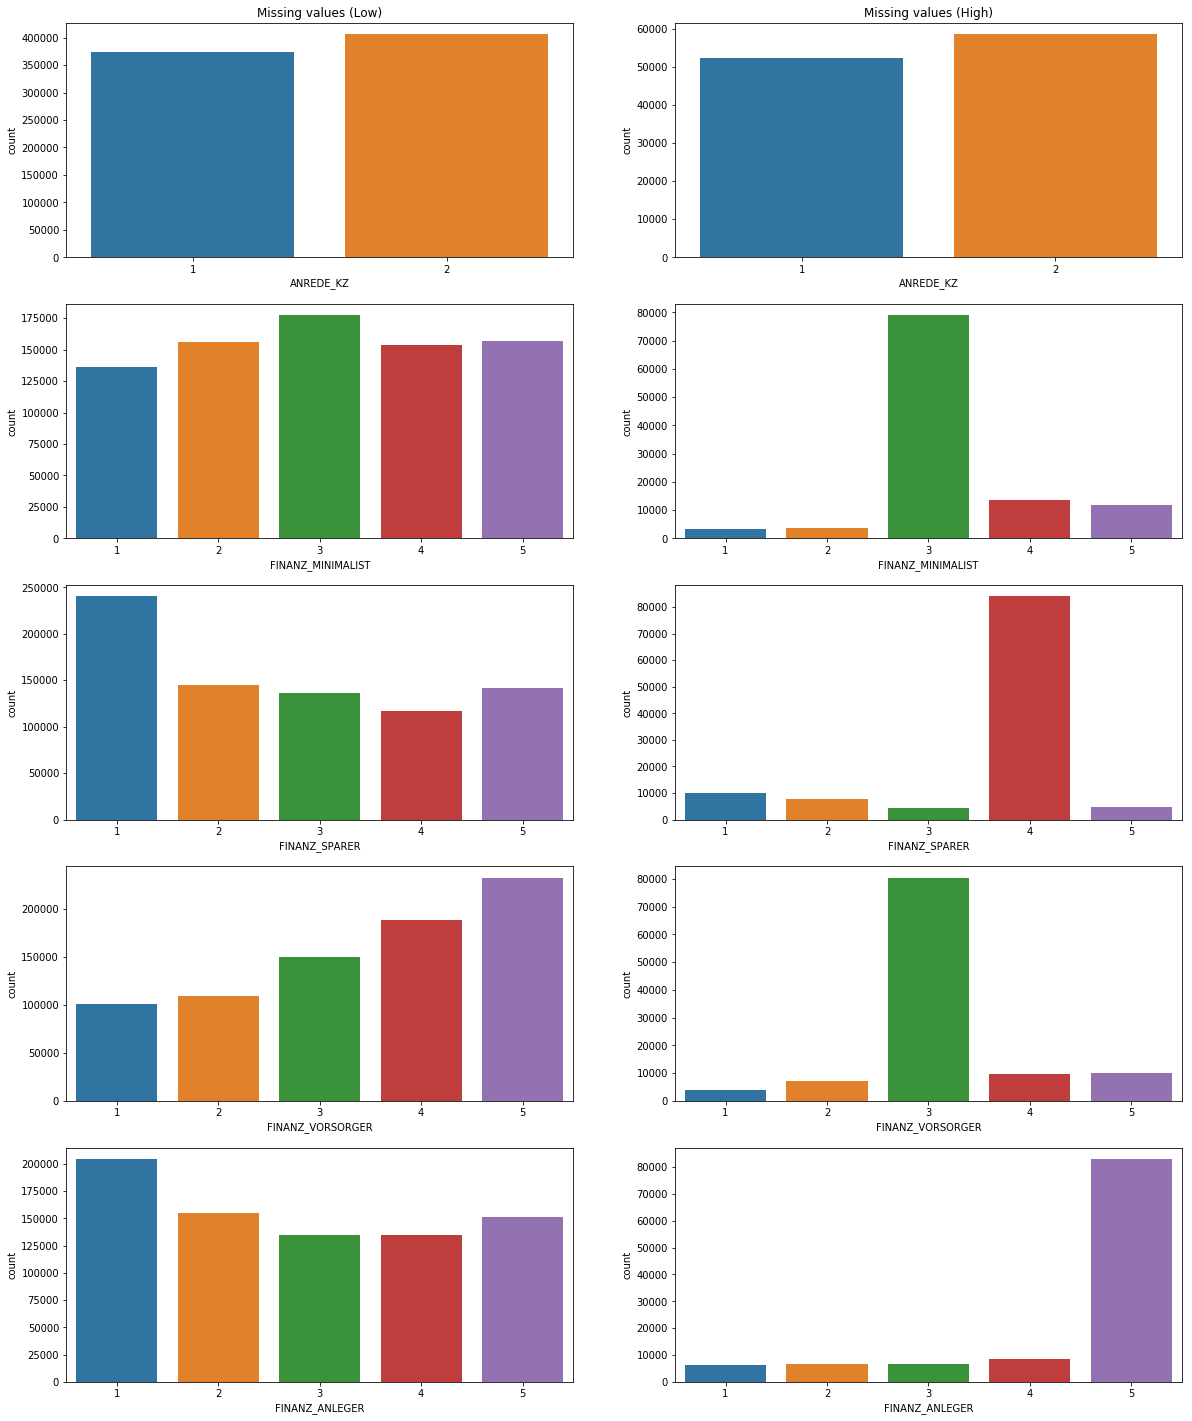

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
small_columns = missing_in_percent.nsmallest(n = 5).index.tolist() #[missing_in_percent > 20]
print(small_columns)

def comparison(columns, df_low, df_high):
    ncol = len(columns)
    fig, ax = plt.subplots(nrows = ncol, ncols = 2, figsize=(20,25))
    ax[0,0].set_title('Missing values (Low)')
    ax[0,1].set_title('Missing values (High)')
    
    for i, col in enumerate(columns):
        sns.countplot(df_low[col], ax = ax[i, 0])
        sns.countplot(df_high[col], ax = ax[i, 1])
    
comparison_plot = comparison(small_columns, azdias_low, azdias_high)
plt.show()


#### Discussion 1.1.3: Assess Missing Data in Each Row

To set the threshold for subseting the data, here we checked the number of missing values for each row and concluded that majority of observations have 10 or smaller missing values. Therefore, we set 10 to be the threshold.

After spliting the data into two different dataframe, we selected five columns, which have the smallest missing values, namely 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER' for the detailed comparison.

The result is somewhat interesting. For the same columns, the distribution of values were different. This is maybe due to the biased samples size, (780182, 79) versus (111039, 79). Still, this bias problem in dataset may cause problem in further analysis.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. **Check the third column of the feature summary (`feat_info`) for a summary of types of measurement**.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?
# feat_info.head(5)
feat_info.groupby('type').count()


attribute  information_level  missing_or_unknown
type                                                         
categorical  21         21                 21                
interval     1          1                  1                 
mixed        7          7                  7                 
numeric      7          7                  7                 
ordinal      49         49                 49

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Get column info
categorical_col = feat_info[feat_info['type'] == 'categorical'].attribute.values
# Get subset of the data from azdias, which have categorical values
azdias_categorical = azdias_low.loc[:, azdias_low.columns.isin(categorical_col)]
azdias_categorical.head()


ANREDE_KZ  CJT_GESAMTTYP  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  \
0  2          5.0            1          10.0             0                  
1  2          3.0            1          10.0             1                  
2  2          2.0            6          1.0              0                  
3  1          5.0            5          5.0              0                  
4  2          2.0            2          1.0              0                  

   LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  LP_STATUS_GROB  \
0  5.0              3.0              2.0             1.0              
1  1.0              1.0              3.0             2.0              
2 NaN              NaN               9.0             4.0              
3  10.0             5.0              3.0             2.0              
4  1.0              1.0              4.0             2.0              

   NATIONALITAET_KZ  SHOPPER_TYP  SOHO_KZ  VERS_TYP  ZABEOTYP  GEBAEUDETYP  \
0  1.0               3.0          1.0      2.0       5         8.0           
1  1.0               2.0          0.0      1.0       5         1.0           
2  1.0               1.0          0.0      1.0       3         1.0           
3  1.0               2.0          0.0      2.0       4         1.0           
4  1.0               0.0          0.0      2.0       4         1.0           

  OST_WEST_KZ CAMEO_DEUG_2015 CAMEO_DEU_2015  
0  W           8               8A             
1  W           4               4C             
2  W           2               2A             
3  W           6               6B             
4  W           8               8C

In [19]:
azdias_categorical.nunique()

ANREDE_KZ           2 
CJT_GESAMTTYP       6 
FINANZTYP           6 
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE    2 
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB     5 
LP_STATUS_FEIN      10
LP_STATUS_GROB      5 
NATIONALITAET_KZ    3 
SHOPPER_TYP         4 
SOHO_KZ             2 
VERS_TYP            2 
ZABEOTYP            6 
GEBAEUDETYP         7 
OST_WEST_KZ         2 
CAMEO_DEUG_2015     9 
CAMEO_DEU_2015      44
dtype: int64

In [20]:
categorical_to_binary = azdias_categorical.columns[azdias_categorical.nunique() == 2].tolist()
print(categorical_to_binary)

for i in categorical_to_binary:
    print( 'Unique values {}: {}'.format(i, azdias_categorical[i].unique()) )

# Make major change to the original dataset: azdias_low
azdias_low['OST_WEST_KZ'] = np.where(azdias_low.OST_WEST_KZ == 'W', 1, 0)
azdias_low.head()


['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Unique values ANREDE_KZ: [2 1]
Unique values GREEN_AVANTGARDE: [0 1]
Unique values SOHO_KZ: [ 1.  0.]
Unique values VERS_TYP: [  2.   1.  nan]
Unique values OST_WEST_KZ: ['W' 'O']


ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0  1.0                   2          5.0            1                   
1  3.0                   2          3.0            1                   
2  4.0                   2          2.0            4                   
3  3.0                   1          5.0            4                   
4  1.0                   2          2.0            3                   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0  5              2                 5               4                       
1  4              1                 2               3                       
2  2              5                 2               1                       
3  3              4                 1               3                       
4  1              5                 2               2                       

   FINANZ_HAUSBAUER  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  \
0  5                 1          10.0             0                 3.0          
1  5                 1          10.0             1                 3.0          
2  2                 6          1.0              0                 2.0          
3  2                 5          5.0              0                 3.0          
4  5                 2          1.0              0                 3.0          

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  \
0  21.0                 6.0                  5.0              3.0               
1  3.0                  1.0                  1.0              1.0               
2 NaN                  NaN                  NaN              NaN                
3  32.0                 10.0                 10.0             5.0               
4  8.0                  2.0                  1.0              1.0               

   LP_STATUS_FEIN  LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
0  2.0             1.0             1.0               14.0                    
1  3.0             2.0             1.0               15.0                    
2  9.0             4.0             1.0               8.0                     
3  3.0             2.0             1.0               8.0                     
4  4.0             2.0             1.0               3.0                     

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
0  1.0             5          4          4          3          1            
1  3.0             4          1          3          3          4            
2  2.0             5          1          2          1          4            
3  5.0             6          4          4          2          7            
4  3.0             2          4          7          4          2            

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
0  2           2          3           6          4           7           
1  4           6          3           4          7           7           
2  4           7          4           3          4           4           
3  4           4          6           2          3           2           
4  2           2          5           7          4           4           

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  VERS_TYP  \
0  4           7              6            3.0          1.0      2.0        
1  7           3              3            2.0          0.0      1.0        
2  5           4              4            1.0          0.0      1.0        
3  2           4              2            2.0          0.0      2.0        
4  4           7              6            0.0          0.0      2.0        

   ZABEOTYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
0  5         2.0           0.0        6.0                 3.0              
1  5         1.0           0.0        4.0                 3.0              
2  3         0.0           0.0        1.0                NaN     

In [21]:
categorical_to_multi = azdias_categorical.columns[azdias_categorical.nunique() > 2].tolist()
print(categorical_to_multi)

for i in categorical_to_multi:
    print( 'Unique values {}: {}'.format(i, azdias_categorical[i].unique()) )

# Make major change to the original dataset: azdias_low    
azdias_low = pd.get_dummies(azdias_low, 
                            prefix = categorical_to_multi, 
                            columns = categorical_to_multi)
azdias_low.head()


['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Unique values CJT_GESAMTTYP: [  5.   3.   2.   4.   1.   6.  nan]
Unique values FINANZTYP: [1 6 5 2 4 3]
Unique values GFK_URLAUBERTYP: [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.  nan]
Unique values LP_FAMILIE_FEIN: [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
Unique values LP_FAMILIE_GROB: [  3.   1.  nan   5.   2.   4.]
Unique values LP_STATUS_FEIN: [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
Unique values LP_STATUS_GROB: [  1.   2.   4.   5.   3.  nan]
Unique values NATIONALITAET_KZ: [  1.   3.   2.  nan]
Unique values SHOPPER_TYP: [  3.   2.   1.   0.  nan]
Unique values ZABEOTYP: [5 3 4 1 6 2]
Unique values GEBAEUDETYP: [ 8.  1.  3.  2.  6.  4.  5.]
Unique values CAMEO_DEUG_2015: ['8' '4' '2' '6' '1' '9' '5' '7' '3

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0  1.0                   2          1                  5               
1  3.0                   2          1                  4               
2  4.0                   2          4                  2               
3  3.0                   1          4                  3               
4  1.0                   2          3                  1               

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0  2                 5               4                      5                  
1  1                 2               3                      5                  
2  5                 2               1                      2                  
3  4                 1               3                      2                  
4  5                 2               2                      5                  

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
0  0                 3.0         21.0                 6.0                   
1  1                 3.0         3.0                  1.0                   
2  0                 2.0        NaN                  NaN                    
3  0                 3.0         32.0                 10.0                  
4  0                 3.0         8.0                  2.0                   

   PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  \
0  14.0                   1.0             5          4          4           
1  15.0                   3.0             4          1          3           
2  8.0                    2.0             5          1          2           
3  8.0                    5.0             6          4          4           
4  3.0                    3.0             2          4          7           

   SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  \
0  3          1           2           2          3           6           
1  3          4           4           6          3           4           
2  1          4           4           7          4           3           
3  2          7           4           4          6           2           
4  4          2           2           2          5           7           

   SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SOHO_KZ  \
0  4           7          4           7              6            1.0       
1  7           7          7           3              3            0.0       
2  4           4          5           4              4            0.0       
3  3           2          2           4              2            0.0       
4  4           4          4           7              6            0.0       

   VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  \
0  2.0       2.0           0.0        6.0                 3.0              
1  1.0       1.0           0.0        4.0                 3.0              
2  1.0       0.0           0.0        1.0                NaN               
3  2.0       4.0           0.0        5.0                 2.0              
4  2.0       1.0           0.0        5.0                 6.0              

   WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  KONSUMNAEHE  \
0  9.0             11.0                 0.0           1.0           
1  9.0             10.0                 0.0           5.0           
2  9.0             1.0                  0.0           4.0           
3  9.0             3.0                  0.0           4.0           
4  9.0             5.0                  0.0           5.0           

   MIN_GEBAEUDEJAHR  OST_WEST_KZ  WOHNLAGE CAMEO_INTL_2015  KBA05_ANTG1  \
0  1992.0            1            4.0       51              0.0           
1  1992.0            1            2.0       24              1.0           
2  1997.0            1            7.0       12              4.0           
3  1992.0            1            3.0       43              1.0           
4  1992.

#### Discussion 1.2.1: Re-Encode Categorical Features

Total 18 categorical features:

- Binary: 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'

- Multi-level: 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'

Regarding the binary categoricals, only `OST_WEST_KZ` is containing non-numerical values. So, we decided to keep other columns as they are and only transformed `OST_WEST_KZ` to numeric - 0 and 1. For multi-level categoricals, we changed all features to dummy variables using pandas.get_dummies function. As a result, we now have 135 columns in the dataset.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, **you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement**.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. **Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values)**.
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

#### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

Decade: {40s: 1, 50s: 2, 60s: 3, 70s: 4, 80s: 5, 90s: 6}
Movement: {Mainstream: 1, Avantgarde: 0}


In [22]:
# Get column info
mixed_col = feat_info[feat_info['type'] == 'mixed'].attribute.values
# Get subset of the data from azdias, which have categorical values
azdias_mixed = azdias.loc[:, azdias.columns.isin(mixed_col)]
azdias_mixed.head()


LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  PRAEGENDE_JUGENDJAHRE  WOHNLAGE  \
0  15.0                 4.0                 NaN                    NaN         
1  21.0                 6.0                  14.0                   4.0        
2  3.0                  1.0                  15.0                   2.0        
3 NaN                  NaN                   8.0                    7.0        
4  32.0                 10.0                 8.0                    3.0        

  CAMEO_INTL_2015  PLZ8_BAUMAX  
0  NaN            NaN           
1  51              1.0          
2  24              1.0          
3  12              1.0          
4  43              2.0

In [23]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
Decade = {1: 1, 2: 1,                 # 40s
          3: 2, 4: 2,                 # 50s
          5: 3, 6: 3, 7: 3,           # 60s
          8: 4, 9: 4,                 # 70s
          10: 5, 11: 5, 12: 5, 13: 5, # 80s
          14: 6, 15: 6}               # 90s
Movement = {1: 1, 2: 0, 
            3: 1, 4: 0, 
            5: 1, 6: 0, 7: 0, 
            8: 1, 9: 0, 
            10: 1, 11: 0, 12: 1, 13: 0, 
            14: 1, 15: 0}

azdias_low["DECADE"] = azdias_low["PRAEGENDE_JUGENDJAHRE"].map(Decade)
azdias_low["MOVEMENT"] = azdias_low["PRAEGENDE_JUGENDJAHRE"].map(Movement)
azdias_low.drop("PRAEGENDE_JUGENDJAHRE", axis = 1)

azdias_low[["DECADE", "MOVEMENT"]].head()


DECADE  MOVEMENT
0  6.0     1.0     
1  6.0     0.0     
2  4.0     1.0     
3  4.0     1.0     
4  2.0     1.0

#### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [24]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_low.loc[azdias_low["CAMEO_INTL_2015"].notnull(), "WEALTH"] = azdias_low.loc[azdias_low["CAMEO_INTL_2015"].notnull(), "CAMEO_INTL_2015"].apply(lambda x: list(map(int, str(x)))[0])
azdias_low.loc[azdias_low["CAMEO_INTL_2015"].notnull(), "LIFE_STYLE"] = azdias_low.loc[azdias_low["CAMEO_INTL_2015"].notnull(), "CAMEO_INTL_2015"].apply(lambda x: list(map(int, str(x)))[1])

azdias_low[["CAMEO_INTL_2015", "WEALTH", "LIFE_STYLE"]].head()
#azdias_low["CAMEO_INTL_2015"].apply(lambda x: list(map(int, str(x)))[0])


CAMEO_INTL_2015  WEALTH  LIFE_STYLE
0  51              5.0     1.0       
1  24              2.0     4.0       
2  12              1.0     2.0       
3  43              4.0     3.0       
4  54              5.0     4.0

In [25]:
# Drop all mixed-type columns
azdias_low.drop(azdias_mixed.columns.tolist(), axis = 1, inplace = True)
azdias_low.head()


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0  1.0                   2          1                  5               
1  3.0                   2          1                  4               
2  4.0                   2          4                  2               
3  3.0                   1          4                  3               
4  1.0                   2          3                  1               

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0  2                 5               4                      5                  
1  1                 2               3                      5                  
2  5                 2               1                      2                  
3  4                 1               3                      2                  
4  5                 2               2                      5                  

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0  0                 3.0         1.0             5          4           
1  1                 3.0         3.0             4          1           
2  0                 2.0         2.0             5          1           
3  0                 3.0         5.0             6          4           
4  0                 3.0         3.0             2          4           

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0  4          3          1           2           2          3            
1  3          3          4           4           6          3            
2  2          1          4           4           7          4            
3  4          2          7           4           4          6            
4  7          4          2           2           2          5            

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0  6          4           7          4           7              6             
1  4          7           7          7           3              3             
2  3          4           4          5           4              4             
3  2          3           2          2           4              2             
4  7          4           4          4           7              6             

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0  1.0      2.0       2.0           0.0        6.0                  
1  0.0      1.0       1.0           0.0        4.0                  
2  0.0      1.0       0.0           0.0        1.0                  
3  0.0      2.0       4.0           0.0        5.0                  
4  0.0      2.0       1.0           0.0        5.0                  

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0  3.0             9.0             11.0                 0.0            
1  3.0             9.0             10.0                 0.0            
2 NaN              9.0             1.0                  0.0            
3  2.0             9.0             3.0                  0.0            
4  6.0             9.0             5.0                  0.0            

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  \
0  1.0          1992.0            1            0.0          0.0           
1  5.0          1992.0            1            1.0          3.0           
2  4.0          1997.0            1            4.0          1.0           
3  4.0          1992.0            1            1.0          4.0           
4  5.0          1992.0            1            2.0          2.0           

   KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  \
0  0.0          2.0          1.0        6.0       3.0       8.0          
1  1.0          0.0          3.0        2.0       4.0       4.0          
2  0.0          0.0          4.0        4.0       2.0       6.0          
3  1.0          0.0          3.0        2.0       5.0       1.0          
4  0.0          0.0          4.0        6.0       2.0       7

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Here, we focused on two mixed-type features, `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015`. Based on the data description, we extracted two categorical variables from each of them. After obtaining total four useful features from these, we dropped all mixed-type features in the dataset as they are no longer needed for further analysis.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [26]:
# Final check for the columns
azdias_low.columns.tolist()


['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'CJT_GESAMTTYP_1.0', 'CJT_GESAMTTYP_2.0', 'CJT_GESAMTTYP_3.0', 'CJT_GESAM

In [27]:
azdias_low.describe()

ALTERSKATEGORIE_GROB      ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count  777528.000000         780153.000000  780153.000000      780153.000000   
mean   2.797778              1.521235       3.050657           2.711548        
std    1.019078              0.499549       1.378001           1.486898        
min    1.000000              1.000000       1.000000           1.000000        
25%    2.000000              1.000000       2.000000           1.000000        
50%    3.000000              2.000000       3.000000           3.000000        
75%    4.000000              2.000000       4.000000           4.000000        
max    4.000000              2.000000       5.000000           5.000000        

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count  780153.000000     780153.000000   780153.000000           
mean   3.439027          2.838339        2.634099                
std    1.376730          1.473251        1.393676                
min    1.000000          1.000000        1.000000                
25%    2.000000          1.000000        1.000000                
50%    4.000000          3.000000        2.000000                
75%    5.000000          4.000000        4.000000                
max    5.000000          5.000000        5.000000                

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE     HEALTH_TYP  RETOURTYP_BK_S  \
count  780153.000000     780153.000000     745629.000000  776319.000000    
mean   3.144031          0.220073          2.203840       3.442805         
std    1.398751          0.414296          0.755139       1.456584         
min    1.000000          0.000000          1.000000       1.000000         
25%    2.000000          0.000000          2.000000       2.000000         
50%    3.000000          0.000000          2.000000       4.000000         
75%    4.000000          0.000000          3.000000       5.000000         
max    5.000000          1.000000          3.000000       5.000000         

           SEMIO_SOZ      SEMIO_FAM      SEMIO_REL      SEMIO_MAT  \
count  780153.000000  780153.000000  780153.000000  780153.000000   
mean   4.156113       4.109600       3.990285       3.869892        
std    1.942423       1.908268       1.910033       1.913476        
min    1.000000       1.000000       1.000000       1.000000        
25%    2.000000       2.000000       3.000000       2.000000        
50%    4.000000       4.000000       4.000000       4.000000        
75%    6.000000       6.000000       5.000000       5.000000        
max    7.000000       7.000000       7.000000       7.000000        

          SEMIO_VERT     SEMIO_LUST      SEMIO_ERL     SEMIO_KULT  \
count  780153.000000  780153.000000  780153.000000  780153.000000   
mean   4.265691       4.354718       4.625775       4.141283        
std    1.937904       2.100573       1.827632       1.956944        
min    1.000000       1.000000       1.000000       1.000000        
25%    2.000000       2.000000       3.000000       3.000000        
50%    5.000000       5.000000       4.000000       4.000000        
75%    6.000000       6.000000       6.000000       6.000000        
max    7.000000       7.000000       7.000000       7.000000        

           SEMIO_RAT     SEMIO_KRIT      SEMIO_DOM     SEMIO_KAEM  \
count  780153.000000  780153.000000  780153.000000  780153.000000   
mean   3.886408       4.535849       4.563405       4.295213        
std    1.654401       1.749112       1.823293       1.869759        
min    1.000000       1.000000       1.000000       1.000000        
25%    3.000000       3.000000       3.000000       3.000000        
50%    4.000000       5.000000       5.000000       4.000000        
75%    5.000000       6.000000       6.000000       6.000000        
max    7.000000       7.000000       7.000000       7.000000        

       SEMIO_PFLICHT    SEMIO_TRADV        SOHO_KZ       VERS_TYP  \
count  780153.000000  780153.000000  780153.000000  745629.000000   
me

In [28]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_low.isnull().sum()


ALTERSKATEGORIE_GROB     2625 
ANREDE_KZ                0    
FINANZ_MINIMALIST        0    
FINANZ_SPARER            0    
FINANZ_VORSORGER         0    
FINANZ_ANLEGER           0    
FINANZ_UNAUFFAELLIGER    0    
FINANZ_HAUSBAUER         0    
GREEN_AVANTGARDE         0    
HEALTH_TYP               34524
RETOURTYP_BK_S           3834 
SEMIO_SOZ                0    
SEMIO_FAM                0    
SEMIO_REL                0    
SEMIO_MAT                0    
SEMIO_VERT               0    
SEMIO_LUST               0    
SEMIO_ERL                0    
SEMIO_KULT               0    
SEMIO_RAT                0    
SEMIO_KRIT               0    
SEMIO_DOM                0    
SEMIO_KAEM               0    
SEMIO_PFLICHT            0    
SEMIO_TRADV              0    
SOHO_KZ                  0    
VERS_TYP                 34524
ANZ_PERSONEN             0    
ANZ_TITEL                0    
HH_EINKOMMEN_SCORE       0    
                        ..    
CAMEO_DEU_2015_5A        0    
CAMEO_DE

In [29]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_low.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780153 entries, 0 to 780152
Columns: 192 entries, ALTERSKATEGORIE_GROB to LIFE_STYLE
dtypes: float64(41), int64(23), uint8(128)
memory usage: 476.2 MB


In [30]:
azdias_low.shape

(780153, 192)

In [31]:
azdias_low.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0  1.0                   2          1                  5               
1  3.0                   2          1                  4               
2  4.0                   2          4                  2               
3  3.0                   1          4                  3               
4  1.0                   2          3                  1               

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0  2                 5               4                      5                  
1  1                 2               3                      5                  
2  5                 2               1                      2                  
3  4                 1               3                      2                  
4  5                 2               2                      5                  

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0  0                 3.0         1.0             5          4           
1  1                 3.0         3.0             4          1           
2  0                 2.0         2.0             5          1           
3  0                 3.0         5.0             6          4           
4  0                 3.0         3.0             2          4           

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0  4          3          1           2           2          3            
1  3          3          4           4           6          3            
2  2          1          4           4           7          4            
3  4          2          7           4           4          6            
4  7          4          2           2           2          5            

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0  6          4           7          4           7              6             
1  4          7           7          7           3              3             
2  3          4           4          5           4              4             
3  2          3           2          2           4              2             
4  7          4           4          4           7              6             

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0  1.0      2.0       2.0           0.0        6.0                  
1  0.0      1.0       1.0           0.0        4.0                  
2  0.0      1.0       0.0           0.0        1.0                  
3  0.0      2.0       4.0           0.0        5.0                  
4  0.0      2.0       1.0           0.0        5.0                  

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0  3.0             9.0             11.0                 0.0            
1  3.0             9.0             10.0                 0.0            
2 NaN              9.0             1.0                  0.0            
3  2.0             9.0             3.0                  0.0            
4  6.0             9.0             5.0                  0.0            

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  \
0  1.0          1992.0            1            0.0          0.0           
1  5.0          1992.0            1            1.0          3.0           
2  4.0          1997.0            1            4.0          1.0           
3  4.0          1992.0            1            1.0          4.0           
4  5.0          1992.0            1            2.0          2.0           

   KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  \
0  0.0          2.0          1.0        6.0       3.0       8.0          
1  1.0          0.0          3.0        2.0       4.0       4.0          
2  0.0          0.0          4.0        4.0       2.0       6.0          
3  1.0          0.0          3.0        2.0       5.0       1.0          
4  0.0          0.0          4.0        6.0       2.0       7

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [57]:
def clean_data(feat_info, df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    ## Identify missing or unknown data values and convert them to NaNs.
    feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[]').str.split(',')
    for index in range(feat_info.shape[0]): 
        for item in range(len(feat_info.loc[index, 'missing_or_unknown'])):
            try: 
                feat_info.loc[index, 'missing_or_unknown'][item] = int( feat_info.loc[index, 'missing_or_unknown'][item] )        
            except: 
                continue
                
        # Replace unknown or missing indicator variables to np.nan
        df.loc[:, feat_info.loc[index, 'attribute']].replace(feat_info.loc[index, 'missing_or_unknown'], 
                                                                 np.nan, inplace = True)

    
    # remove selected columns and rows, ...
    # Remove columns with largest number of missing data
    #missing_col = azdias.isnull().sum()
    #missing_in_percent = missing_col / len(azdias) * 100
    #top_columns = missing_in_percent[missing_in_percent > 20]
    # Using the top_columns calculated above 
    df = df.drop(top_columns.index.tolist(), axis = 1)
    
    missing_rows = df.isnull().sum(axis = 1)
    # Divide into two groups based on the missing value of 10
    df_low = df[missing_rows <= 10].reset_index(drop = True) # Main dataset
    df_high = df[missing_rows > 10].reset_index(drop = True)
    
    # select, re-encode, and engineer column values.
    # Categorical
    categorical_col = feat_info[feat_info['type'] == 'categorical'].attribute.values
    df_categorical = df_low.loc[:, df_low.columns.isin(categorical_col)]
    df_to_binary = df_categorical.columns[df_categorical.nunique() == 2].tolist()
    df_to_multi = df_categorical.columns[df_categorical.nunique() > 2].tolist()
    # Make major change to the original dataset: azdias_low
    df_low['OST_WEST_KZ'] = np.where(df_low.OST_WEST_KZ == 'W', 1, 0)
    df_low = pd.get_dummies(df_low, prefix = categorical_to_multi, 
                            columns = categorical_to_multi)
    
    # Mixed-type
    mixed_col = feat_info[feat_info['type'] == 'mixed'].attribute.values
    Decade = {1: 1, 2: 1,                 # 40s
              3: 2, 4: 2,                 # 50s
              5: 3, 6: 3, 7: 3,           # 60s
              8: 4, 9: 4,                 # 70s
              10: 5, 11: 5, 12: 5, 13: 5, # 80s
              14: 6, 15: 6}               # 90s
    Movement = {1: 1, 2: 0, 
                3: 1, 4: 0, 
                5: 1, 6: 0, 7: 0, 
                8: 1, 9: 0, 
                10: 1, 11: 0, 12: 1, 13: 0, 
                14: 1, 15: 0}
    df_low["DECADE"] = df_low["PRAEGENDE_JUGENDJAHRE"].map(Decade)
    df_low["MOVEMENT"] = df_low["PRAEGENDE_JUGENDJAHRE"].map(Movement)
    df_low.drop("PRAEGENDE_JUGENDJAHRE", axis = 1)
    df_low.loc[df_low["CAMEO_INTL_2015"].notnull(), "WEALTH"] = df_low.loc[df_low["CAMEO_INTL_2015"].notnull(), "CAMEO_INTL_2015"].apply(lambda x: list(map(int, str(x)))[0])
    df_low.loc[df_low["CAMEO_INTL_2015"].notnull(), "LIFE_STYLE"] = df_low.loc[df_low["CAMEO_INTL_2015"].notnull(), "CAMEO_INTL_2015"].apply(lambda x: list(map(int, str(x)))[1])
    df_low.drop(azdias_mixed.columns.tolist(), axis = 1, inplace = True)
    
    # Customer dataset does not have one column --> fill in zero
    columns = [col for col in azdias_low if col not in df_low]
    for column in columns:
        df_low[column] = 0

    
    # Return the cleaned dataframe.
    return df_low
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [33]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer(strategy = "mean", missing_values = np.nan, axis = 0)
azdias_low = pd.DataFrame(imputer.fit_transform(azdias_low), 
                          columns = azdias_low.columns)
azdias_low.head()


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0  1.0                   2.0        1.0                5.0             
1  3.0                   2.0        1.0                4.0             
2  4.0                   2.0        4.0                2.0             
3  3.0                   1.0        4.0                3.0             
4  1.0                   2.0        3.0                1.0             

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0  2.0               5.0             4.0                    5.0                
1  1.0               2.0             3.0                    5.0                
2  5.0               2.0             1.0                    2.0                
3  4.0               1.0             3.0                    2.0                
4  5.0               2.0             2.0                    5.0                

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0  0.0               3.0         1.0             5.0        4.0         
1  1.0               3.0         3.0             4.0        1.0         
2  0.0               2.0         2.0             5.0        1.0         
3  0.0               3.0         5.0             6.0        4.0         
4  0.0               3.0         3.0             2.0        4.0         

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0  4.0        3.0        1.0         2.0         2.0        3.0          
1  3.0        3.0        4.0         4.0         6.0        3.0          
2  2.0        1.0        4.0         4.0         7.0        4.0          
3  4.0        2.0        7.0         4.0         4.0        6.0          
4  7.0        4.0        2.0         2.0         2.0        5.0          

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0  6.0        4.0         7.0        4.0         7.0            6.0           
1  4.0        7.0         7.0        7.0         3.0            3.0           
2  3.0        4.0         4.0        5.0         4.0            4.0           
3  2.0        3.0         2.0        2.0         4.0            2.0           
4  7.0        4.0         4.0        4.0         7.0            6.0           

   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0  1.0      2.0       2.0           0.0        6.0                  
1  0.0      1.0       1.0           0.0        4.0                  
2  0.0      1.0       0.0           0.0        1.0                  
3  0.0      2.0       4.0           0.0        5.0                  
4  0.0      2.0       1.0           0.0        5.0                  

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0  3.000000        9.0             11.0                 0.0            
1  3.000000        9.0             10.0                 0.0            
2  4.175552        9.0             1.0                  0.0            
3  2.000000        9.0             3.0                  0.0            
4  6.000000        9.0             5.0                  0.0            

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  \
0  1.0          1992.0            1.0          0.0          0.0           
1  5.0          1992.0            1.0          1.0          3.0           
2  4.0          1997.0            1.0          4.0          1.0           
3  4.0          1992.0            1.0          1.0          4.0           
4  5.0          1992.0            1.0          2.0          2.0           

   KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  \
0  0.0          2.0          1.0        6.0       3.0       8.0          
1  1.0          0.0          3.0        2.0       4.0       4.0          
2  0.0          0.0          4.0        4.0       2.0       6.0          
3  1.0          0.0          3.0        2.0       5.0       1.0          
4  0.0          0.0          4.0        6.0       2.0       7

In [34]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_low = pd.DataFrame(scaler.fit_transform(azdias_low), 
                          columns = azdias_low.columns)
azdias_low.head()


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0 -1.767099              0.958395  -1.488140           1.539080        
1  0.198771              0.958395  -1.488140           0.866538        
2  1.181706              0.958395   0.688928          -0.478545        
3  0.198771             -1.043411   0.688928           0.193996        
4 -1.767099              0.958395  -0.036761          -1.151087        

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0 -1.045251          1.467273        0.980071               1.326876           
1 -1.771610         -0.569041        0.262544               1.326876           
2  1.133828         -0.569041       -1.172510              -0.817895           
3  0.407468         -1.247812        0.262544              -0.817895           
4  1.133828         -0.569041       -0.454983               1.326876           

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0 -0.531199          1.078455   -1.681216        0.434451  -0.057434    
1  1.882535          1.078455   -0.304752       -0.080370  -1.629542    
2 -0.531199         -0.276116   -0.992984        0.434451  -1.629542    
3 -0.531199          1.078455    1.071711        0.949272  -0.057434    
4 -0.531199          1.078455   -0.304752       -1.110013  -0.057434    

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0  0.005086  -0.454614  -1.685168   -1.120989   -1.436709  -0.583197     
1 -0.518465  -0.454614  -0.137103   -0.168867    0.751916  -0.583197     
2 -1.042017  -1.499833  -0.137103   -0.168867    1.299072  -0.072196     
3  0.005086  -0.977223   1.410963   -0.168867   -0.342397   0.949807     
4  1.575741   0.067996  -1.169146   -1.120989   -1.436709   0.438806     

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0  1.277558  -0.306355    1.336372  -0.157888    1.505994       1.290984      
1  0.068660   1.408802    1.336372   1.446598   -0.632808      -0.410671      
2 -0.535788  -0.306355   -0.309004   0.376940   -0.098107       0.156547      
3 -1.140237  -0.878074   -1.405922  -1.227545   -0.098107      -0.977890      
4  1.882007  -0.306355   -0.309004  -0.157888    1.505994       1.290984      

     SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0  10.871068  0.978131  0.229631     -0.060808   1.011783             
1 -0.091987  -1.069695 -0.633119     -0.060808  -0.285204             
2 -0.091987  -1.069695 -1.495869     -0.060808  -2.230685             
3 -0.091987   0.978131  1.955131     -0.060808   0.363290             
4 -0.091987   0.978131 -0.633119     -0.060808   0.363290             

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0 -6.878200e-01    0.553949        0.163066            -0.126267       
1 -6.878200e-01    0.553949        0.099318            -0.126267       
2  1.039353e-15    0.553949       -0.474416            -0.126267       
3 -1.272924e+00    0.553949       -0.346919            -0.126267       
4  1.067492e+00    0.553949       -0.219423            -0.126267       

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  \
0 -1.299636    -0.391262          0.518769    -1.081112    -1.032570      
1  1.282137    -0.391262          0.518769    -0.357702     1.415025      
2  0.636694     1.584548          0.518769     1.812528    -0.216705      
3  0.636694    -0.391262          0.518769    -0.357702     2.230890      
4  1.282137    -0.391262          0.518769     0.365708     0.599160      

   KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  \
0 -0.626328     2.693819    -1.649104   0.848197 -0.552825  1.704377     
1  0.375773    -0.486610    -0.120483  -0.982252  0.029427 -0.266435     
2 -0.626328    -0.486610     0.643828  -0.067027 -1.135077  0.718971     
3  0.375773    -0.486610    -0.120483  -0.982252  0.611678 -1.744543     
4 -0.626328    -0.486610     0.643828   0.848197 

### Discussion 2.1: Apply Feature Scaling

For missing and NaN values, we Imputer package to replace it with mean of each column. 
(Reference: https://scikit-learn.org/stable/modules/impute.html)

Then for the scaling, as suggested in the problem, we used StandardScaler package to scale the entire dataset.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [35]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_low)


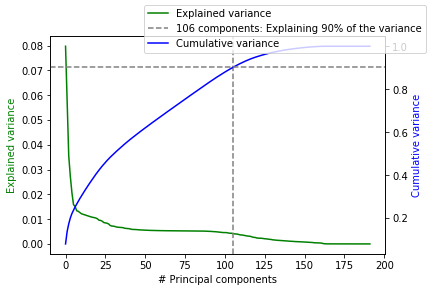

In [36]:
# Investigate the variance accounted for by each principal component.
# Number of components needed to explain 90% of the total variance
components = min(np.where( np.cumsum(pca.explained_variance_ratio_) > 0.9 )[0])

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(pca.explained_variance_ratio_, 'g-', label = "Explained variance") 
ax1.axvline(components, linestyle = 'dashed', color = 'gray', label = "{} components: Explaining 90% of the variance".format(components + 1))
ax2.plot(np.cumsum(pca.explained_variance_ratio_), 'b-', label = "Cumulative variance") 
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[components], linestyle = 'dashed', color = 'gray')

ax1.set_xlabel('# Principal components')
ax1.set_ylabel('Explained variance', color='g')
ax2.set_ylabel('Cumulative variance', color='b')
fig.legend()
plt.show()



In [37]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 50)
azdias_pca = pca.fit_transform(azdias_low)
print( "With 50 components, {}% of the total variance is explained".format(pca.explained_variance_ratio_.sum() * 100) )

pca = PCA(n_components = 70)
azdias_pca = pca.fit_transform(azdias_low)
print( "With 70 components, {}% of the total variance is explained".format(pca.explained_variance_ratio_.sum() * 100) )

pca = PCA(n_components = 106)
azdias_pca = pca.fit_transform(azdias_low)
print( "With 106 components, {}% of the total variance is explained".format(pca.explained_variance_ratio_.sum() * 100) )



With 50 components, 60.84399399068444% of the total variance is explained
With 70 components, 71.74038799472022% of the total variance is explained
With 106 components, 90.04476002206879% of the total variance is explained


### Discussion 2.2: Perform Dimensionality Reduction

In this section, we focused on figuring out the number of components needed to explain the targeted level variance, 90%. To achieve this level, at least 106 components were needed. This number is about one half of the original number of variables, which definitely enhancing the computing efficiency.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, **you should map each weight to their corresponding feature name, then sort the features according to weight**. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [38]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def sort_pca_weights(pca, rank, col_list):
    df = pd.DataFrame(pca.components_, columns = col_list)
    # Reflect python index (starting from zero)
    weights = df.iloc[rank-1].sort_values(ascending = False)    
    weights.plot.bar(figsize = (14, 6))
    plt.ylabel("Weights")
    plt.xlabel("Variables")
    plt.show()
    
    return weights


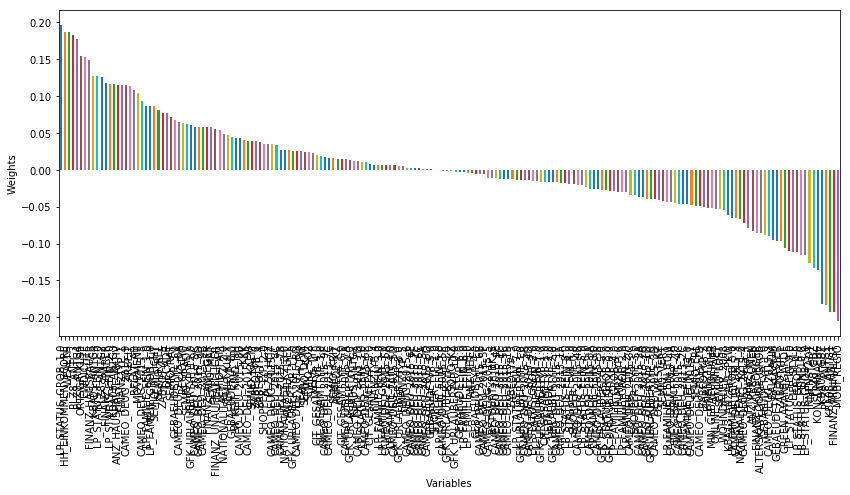

LP_STATUS_GROB_1.0      0.196068
HH_EINKOMMEN_SCORE      0.186321
WEALTH                  0.186029
PLZ8_ANTG3              0.182130
PLZ8_ANTG4              0.176219
ORTSGR_KLS9             0.154208
EWDICHTE                0.152867
FINANZ_HAUSBAUER        0.148726
KBA05_ANTG4             0.127211
LP_STATUS_FEIN_1.0      0.126601
PLZ8_ANTG2              0.125025
FINANZ_SPARER           0.117374
LP_STATUS_FEIN_2.0      0.116357
KBA05_ANTG3             0.115090
ANZ_HAUSHALTE_AKTIV     0.115045
FINANZTYP_1             0.114380
CAMEO_DEUG_2015_9       0.113895
ARBEIT                  0.113486
RELAT_AB                0.107162
MOVEMENT                0.103636
CAMEO_DEUG_2015_8       0.092342
LP_FAMILIE_FEIN_1.0     0.086617
LP_FAMILIE_GROB_1.0     0.086617
SEMIO_PFLICHT           0.085462
SEMIO_REL               0.081014
ZABEOTYP_5              0.076977
DECADE                  0.075870
SEMIO_RAT               0.071341
GEBAEUDETYP_3.0         0.067040
CAMEO_DEU_2015_8A       0.063768
          

In [39]:
weights = sort_pca_weights(pca, 1, azdias_low.columns.tolist())
weights

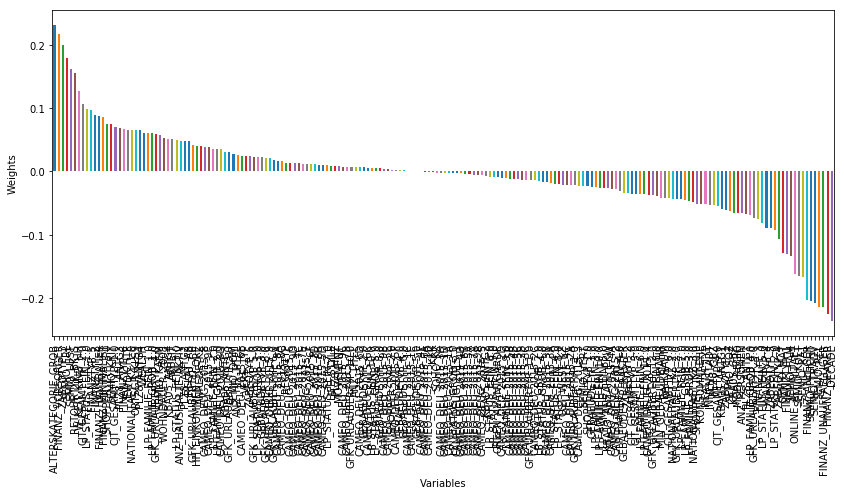

ALTERSKATEGORIE_GROB     0.232328
FINANZ_VORSORGER         0.217792
ZABEOTYP_3               0.199898
SEMIO_ERL                0.180251
SEMIO_LUST               0.162435
RETOURTYP_BK_S           0.156162
W_KEIT_KIND_HH           0.127436
CJT_GESAMTTYP_2.0        0.107367
LP_STATUS_FEIN_1.0       0.098613
FINANZTYP_5              0.097442
FINANZTYP_2              0.089775
FINANZ_HAUSBAUER         0.087626
FINANZ_MINIMALIST        0.085682
SHOPPER_TYP_3.0          0.075404
SEMIO_KRIT               0.074733
CJT_GESAMTTYP_1.0        0.070365
PLZ8_ANTG3               0.068779
FINANZTYP_6              0.066604
EWDICHTE                 0.066261
NATIONALITAET_KZ_1.0     0.065420
ORTSGR_KLS9              0.065078
PLZ8_ANTG4               0.064884
WEALTH                   0.060994
LP_FAMILIE_FEIN_1.0      0.060489
LP_FAMILIE_GROB_1.0      0.060489
GFK_URLAUBERTYP_4.0      0.059001
SEMIO_KAEM               0.058297
WOHNDAUER_2008           0.053029
KBA05_ANTG4              0.051959
ARBEIT        

In [40]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights = sort_pca_weights(pca, 2, azdias_low.columns.tolist())
weights


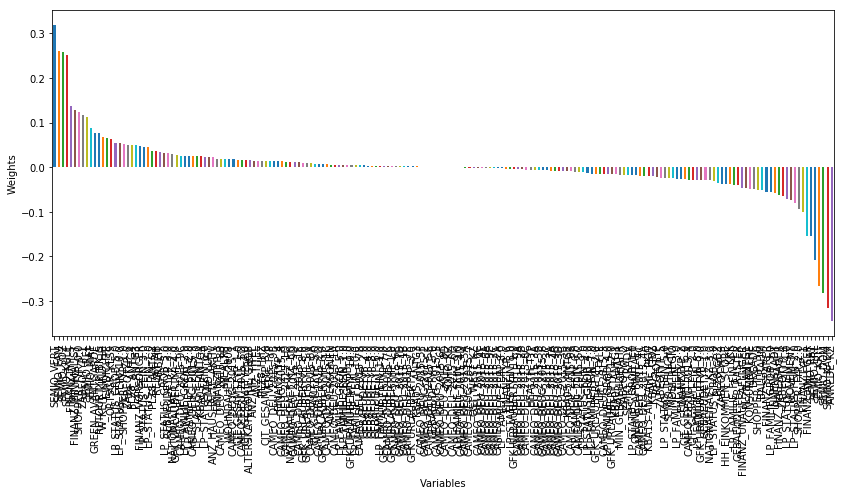

SEMIO_VERT               0.319447
SEMIO_FAM                0.260168
SEMIO_SOZ                0.257598
SEMIO_KULT               0.250180
FINANZTYP_5              0.136139
FINANZ_MINIMALIST        0.129074
SHOPPER_TYP_0.0          0.123701
ZABEOTYP_1               0.116647
SEMIO_REL                0.113406
SEMIO_MAT                0.087992
GREEN_AVANTGARDE         0.076261
RETOURTYP_BK_S           0.075443
W_KEIT_KIND_HH           0.067326
EWDICHTE                 0.064365
ORTSGR_KLS9              0.064159
LP_STATUS_GROB_5.0       0.053430
LP_STATUS_FEIN_10.0      0.053430
SHOPPER_TYP_1.0          0.051487
ZABEOTYP_6               0.050188
PLZ8_ANTG4               0.049672
PLZ8_ANTG3               0.049496
FINANZ_VORSORGER         0.046678
LP_STATUS_FEIN_3.0       0.045058
LP_STATUS_FEIN_1.0       0.044408
PLZ8_ANTG2               0.036022
RELAT_AB                 0.035146
ARBEIT                   0.033767
LP_STATUS_GROB_3.0       0.032545
GEBAEUDETYP_3.0          0.030889
NATIONALITAET_

In [41]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights = sort_pca_weights(pca, 3, azdias_low.columns.tolist())
weights


### Discussion 2.3: Interpret Principal Components

As we expected, the first component shows larger number of variables having positive weights, compared to the second and the third components. One interesting result here is that the variable with the largest weight is `LP_STATUS_GROB_1.0`, which indicate low-income earners, and this may need further analysis on their life style or living status. Besides, `WEALTH` having a positive weight and `FINANZ_MINIMALIST (low financial interest individuals)` having a negative weight seems reasonable.

cf. Top 5 variables with positive weights
1. The first component

| Variable name | Weights | Description | 
| -- | -- | -- |
|LP_STATUS_GROB_1.0  |    0.196068 | low-income earners |
|HH_EINKOMMEN_SCORE  |    0.186321 | .|
|WEALTH              |    0.186029 | .|
|PLZ8_ANTG3          |    0.182130 | Number of 6-10 family houses in the PLZ8 region |
|PLZ8_ANTG4          |    0.176219 | Number of 10+ family houses in the PLZ8 region |

2. The second component

| Variable name | Weights | Description | 
| -- | -- | -- |
|ALTERSKATEGORIE_GROB  |   0.232328 | Estimated age based on given name analysis |
|FINANZ_VORSORGER      |   0.217792 | Financial typology (very prepared)|
|ZABEOTYP_3            |   0.199898 | Energy consumption typology (fair supplied)|
|SEMIO_ERL             |   0.180251 | Personality typology (event-oriented)|
|SEMIO_LUST            |   0.162435 | Personality typology (sensual-minded)|

3. The third component

| Variable name | Weights | Description | 
| -- | -- | -- |
| SEMIO_VERT   |             0.319448 | dreamful| 
| SEMIO_FAM    |             0.260168 | family-minded| 
| SEMIO_SOZ    |             0.257598 | socially-minded| 
| SEMIO_KULT   |             0.250180 | cultural-minded| 
| FINANZTYP_5  |             0.136138 | Most descriptive financial type for individual (investor (ANLEGER))| 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- **Perform the above two steps for a number of different cluster counts**. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [42]:
# Over a number of different cluster counts...
KMeans_scores = []
clusters = range(1, 11, 1)
for k in clusters: # number of clusters
    print(k)
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters = k)
    model = kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    #score = model.score(azdias_pca)
    # apply abs() to prevent negative scores
    KMeans_scores.append( np.abs(model.score(azdias_pca)) )
    

1
2
3
4
5
6
7
8
9
10


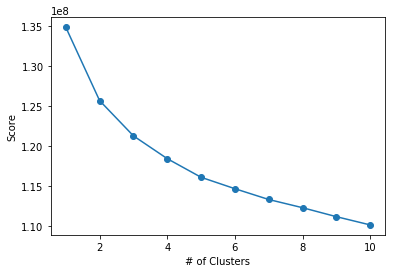

In [43]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, KMeans_scores, linestyle='-', marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.show()


In [44]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# for k in range(5, 21, 5):
#     kmeans = KMeans(n_clusters = k)
#     model = kmeans.fit(azdias_pca)
#     model.predict(azdias_pca)

kmeans = KMeans(n_clusters = 6) # or 5..?
model = kmeans.fit(azdias_pca)
kmeans_pred = model.predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

Here, we chose number of clusters to be 6, where the average distance becomes reasonably smaller compared to smaller number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [58]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter = ';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')
#customers.columns.tolist()
customers_cleaned = clean_data(feat_info, customers)
# customers_cleaned.shape


In [59]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
#imputer = Imputer(strategy = "mean", missing_values = np.nan, axis = 0)
customers_cleaned = pd.DataFrame(imputer.fit_transform(customers_cleaned), 
                                 columns = customers_cleaned.columns)

#scaler = StandardScaler()
customers_cleaned = pd.DataFrame(scaler.fit_transform(customers_cleaned), 
                                 columns = customers_cleaned.columns)

customers_cleaned.head()


ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0  0.700004             -0.702090   0.719536          -0.512607        
1  0.700004              1.424318   0.719536          -0.512607        
2  0.700004             -0.702090   0.719536          -0.512607        
3 -0.681028             -0.702090  -1.246115          -0.512607        
4 -0.681028             -0.702090   0.719536          -0.512607        

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0  0.512420         -0.597750        0.159814              -0.565048           
1  0.512420         -0.597750        2.232557               0.956068           
2  0.512420          0.403598       -0.876558              -0.565048           
3 -0.680895          2.406293        3.268929              -0.565048           
4  0.512420         -0.597750        0.159814               0.195510           

   GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0  0.996755         -1.260370    0.921017        1.023129   0.664950    
1  0.996755          0.044356    0.921017       -1.448515  -1.126970    
2 -1.003256          0.044356   -0.781385        1.023129   0.664950    
3 -1.003256          1.349081    0.921017       -0.212693   0.664950    
4  0.996755          1.349081   -0.781385        1.023129   0.067643    

   SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0 -0.812281   1.278114   0.462481    0.901414   -1.070565   0.047310     
1 -1.499513  -0.235857  -1.243717    0.901414    1.212873  -1.664853     
2 -0.125050   0.268800   1.031213   -0.331749   -1.070565   0.047310     
3  0.562182   1.278114  -0.106252    0.284832   -0.499705   0.618031     
4  0.562182  -1.245171   1.031213    0.284832   -0.499705   1.188752     

   SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  \
0 -1.348960  -0.510716   -1.892810  -1.445743   -0.706915      -1.374438      
1 -0.630549   1.746745    0.625353   1.340788    0.687464      -1.374438      
2  0.087862  -0.510716   -0.633728  -0.331130   -0.009726       0.786887      
3  1.524684  -0.510716    0.625353  -0.888437    1.384653       0.786887      
4 -0.630549   0.618014    0.625353  -0.331130   -0.009726       0.786887      

    SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  \
0 -0.099525 -1.002489 -0.201640     -0.134218  -1.358429             
1 -0.099525  1.012893 -0.919680     -0.134218  -1.358429             
2 -0.099525 -1.002489 -1.637720     -0.134218   0.447396             
3 -0.099525  1.012893  1.234441     -0.134218   1.651279             
4 -0.099525  1.012893 -0.201640     -0.134218  -1.358429             

   W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
0  9.431631e-01    0.28869        -2.816657e-01        -0.124822       
1  9.431631e-01    0.28869        -2.816657e-01        -0.124822       
2 -9.701642e-16    0.28869        -6.179182e-17         0.000000       
3 -1.241452e+00    0.28869         1.357628e-01        -0.124822       
4  9.431631e-01    0.28869        -2.816657e-01        -0.124822       

   KONSUMNAEHE  MIN_GEBAEUDEJAHR  OST_WEST_KZ  KBA05_ANTG1  KBA05_ANTG2  \
0  1.292448    -0.345159          0.294546    -0.152289     0.738107      
1 -1.486120    -0.345159          0.294546    -0.152289     0.738107      
2 -0.791478    -0.345159          0.294546     0.580759    -1.129250      
3 -1.486120    -0.345159          0.294546    -1.618384     1.671785      
4 -0.791478    -0.345159          0.294546    -0.152289     0.738107      

   KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  \
0 -0.410717    -0.325957     0.321163  -0.614701 -1.170923 -0.399358     
1 -0.410717    -0.325957    -0.547169   1.276764  0.073043 -1.929503     
2 -0.410717    -0.325957     0.321163   1.276764 -1.792905  1.130788     
3  2.239884    -0.325957    -0.547169  -0.614701  0.073043 -0.399358     
4  0.914583    -0.325957    -0.547169   1.276764  0.695

In [62]:
#customers_cleaned.shape
#azdias_low.shape
customers_cleaned_pca = pca.transform(customers_cleaned)
customers_cleaned_clustered = model.predict(customers_cleaned_pca)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

**Consider the proportion of persons in each cluster for the general population, and the proportions for the customers**. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

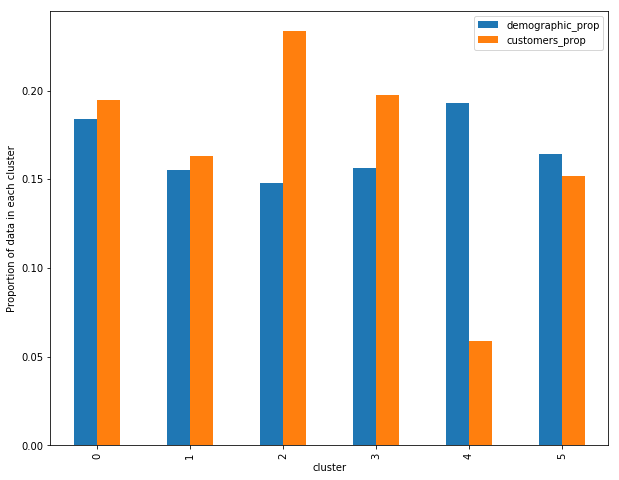

In [69]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# kmeans_pred vs. customers_cleaned_clustered
demographic_prop = []
customers_prop = []
for i in range(6): # number of clusters
    demographic_prop.append((kmeans_pred == i).sum() / len(kmeans_pred))
    customers_prop.append((customers_cleaned_clustered == i).sum() / len(customers_cleaned_clustered))

# Merge all results into one dataframe
df_clustered = pd.DataFrame({'cluster' : [i for i in range(6)], 
                             'demographic_prop' : demographic_prop, 
                             'customers_prop': customers_prop})

df_clustered.plot(x = 'cluster', y = ['demographic_prop', 'customers_prop'], kind = 'bar', figsize = (10, 8))
plt.ylabel('Proportion of data in each cluster')
plt.show()


#fig, ax1 = plt.subplots()
# fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 14))
# # ax2 = ax1.twinx()

# sns.distplot(kmeans_pred, label = 'Demographics',ax = ax[0, 1])
# sns.distplot(customers_cleaned_clustered, label = 'Customer', ax = ax[0, 1])
# sns.countplot(kmeans_pred, label = 'Demographics', ax = ax[1, 1])
# sns.countplot(customers_cleaned_clustered, label = 'Customer', ax = ax[1, 1])
# ax.legend()



In [65]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
overrepresented = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[2]))
overrepresented = pd.DataFrame(data = overrepresented, index = list(customers_cleaned))
overrepresented.head()


0
ALTERSKATEGORIE_GROB  3.787344
ANREDE_KZ             1.290468
FINANZ_MINIMALIST     5.338341
FINANZ_SPARER         0.929226
FINANZ_VORSORGER      4.918086

In [66]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresented = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[4]))
underrepresented = pd.DataFrame(data = underrepresented, index = list(customers_cleaned))
underrepresented.head()


0
ALTERSKATEGORIE_GROB  2.791385
ANREDE_KZ             1.411810
FINANZ_MINIMALIST     2.993602
FINANZ_SPARER         2.421188
FINANZ_VORSORGER      3.749964

In [67]:
result = pd.concat([overrepresented, underrepresented], axis = 1)
result

0         0
ALTERSKATEGORIE_GROB   3.787344  2.791385
ANREDE_KZ              1.290468  1.411810
FINANZ_MINIMALIST      5.338341  2.993602
FINANZ_SPARER          0.929226  2.421188
FINANZ_VORSORGER       4.918086  3.749964
FINANZ_ANLEGER         1.009603  2.478627
FINANZ_UNAUFFAELLIGER  1.619027  2.698891
FINANZ_HAUSBAUER       1.674467  3.660943
GREEN_AVANTGARDE       1.414730  0.302045
HEALTH_TYP             1.865950  2.018948
RETOURTYP_BK_S         4.045054  3.193568
SEMIO_SOZ              4.345978  4.596115
SEMIO_FAM              3.470007  4.637828
SEMIO_REL              2.602971  4.479228
SEMIO_MAT              2.916337  4.476411
SEMIO_VERT             5.626136  4.641362
SEMIO_LUST             6.057145  4.587520
SEMIO_ERL              5.201496  3.866873
SEMIO_KULT             3.546065  4.790119
SEMIO_RAT              2.405836  4.045159
SEMIO_KRIT             3.681522  3.824094
SEMIO_DOM              4.079422  4.258361
SEMIO_KAEM             3.456748  3.988120
SEMIO_PFLICHT          2.426484  4.326595
SEMIO_TRADV            2.540650  4.032151
SOHO_KZ                0.010747  0.010152
VERS_TYP               1.470794  1.474025
ANZ_PERSONEN           2.961005  1.927668
ANZ_TITEL              0.039552  0.015079
HH_EINKOMMEN_SCORE     0.989156  4.520923
...                         ...       ...
CAMEO_DEU_2015_5B      0.006545  0.012839
CAMEO_DEU_2015_5C      0.010266  0.003729
CAMEO_DEU_2015_5D      0.027256  0.021163
CAMEO_DEU_2015_5E      0.005489  0.005989
CAMEO_DEU_2015_5F      0.009557  0.006107
CAMEO_DEU_2015_6A      0.008919  0.002910
CAMEO_DEU_2015_6B      0.056883  0.078428
CAMEO_DEU_2015_6C      0.011009  0.013841
CAMEO_DEU_2015_6D      0.006551  0.008186
CAMEO_DEU_2015_6E      0.019587  0.020159
CAMEO_DEU_2015_6F     -0.000953  0.006286
CAMEO_DEU_2015_7A      0.025112  0.026442
CAMEO_DEU_2015_7B      0.005275  0.033723
CAMEO_DEU_2015_7C     -0.003196  0.018054
CAMEO_DEU_2015_7D      0.000506  0.009259
CAMEO_DEU_2015_7E      0.002484  0.009679
CAMEO_DEU_2015_8A      0.026212  0.027364
CAMEO_DEU_2015_8B     -0.011438  0.072506
CAMEO_DEU_2015_8C     -0.003934  0.044157
CAMEO_DEU_2015_8D     -0.003663  0.031247
CAMEO_DEU_2015_9A     -0.003681  0.008504
CAMEO_DEU_2015_9B     -0.004731  0.026627
CAMEO_DEU_2015_9C     -0.008173  0.031094
CAMEO_DEU_2015_9D     -0.006551  0.044783
CAMEO_DEU_2015_9E     -0.007395  0.035963
DECADE                 2.761960  2.800532
MOVEMENT               0.308337  0.965909
WEALTH                 0.044707  3.134052
LIFE_STYLE             2.197616  4.348196
GEBAEUDETYP_5.0        0.502603 -0.552959

[192 rows x 2 columns]

### Discussion 3.3: Compare Customer Data to Demographics Data

When comparing the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population, the customer data is overrepresented in cluster 2 and underrepresented in cluster 4. Cluster 2 can be described as the following: 
* 46- ~ 60-year-old (ALTERSKATEGORIE_GROB 3.787344);
* male (ANREDE_KZ, 1.290468); and 
* people with low financial interest (FINANZ_MINIMALIST, 5.338341)

Cluster 4 can be described as the following: 
* 30 - 45 years old (ALTERSKATEGORIE_GROB, 2.791385)
* male (ANREDE_KZ, 1.411810); and 
* people with average level of financial interest (FINANZ_MINIMALIST, 2.993602)



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [71]:
!!jupyter nbconvert *.html


["[NbConvertApp] WARNING | pattern '*.html' matched no files", 'This application is used to convert notebook files (*.ipynb) to various other', 'formats.', '', 'WARNING: THE COMMANDLINE INTERFACE MAY CHANGE IN FUTURE RELEASES.', '', 'Options', '-------', '', 'Arguments that take values are actually convenience aliases to full', 'Configurables, whose aliases are listed on the help line. For more information', "on full configurables, see '--help-all'.", '', '--debug', '    set log level to logging.DEBUG (maximize logging output)', '--generate-config', '    generate default config file', '-y', '    Answer yes to any questions instead of prompting.', '--execute', '    Execute the notebook prior to export.', '--allow-errors', "    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.", '--stdin', "    read a single note